In [1]:
import gym
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from moviepy.editor import ImageSequenceClip

import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os

import random
import math

display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    mp4list = glob.glob('/tmp/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

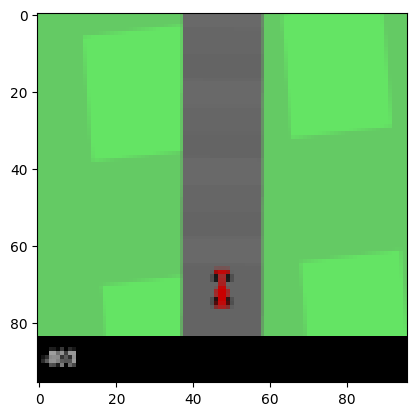

In [2]:
env = gym.make('CarRacing-v2')

observation, _ = env.reset()
env.render()

# Clear frames
for i in range(100):
    action = (0,0,0)
    observation, reward, done, _, info = env.step(action)

plt.imshow(observation)

# State description

$$
\begin{bmatrix} car \; position  \end{bmatrix}
$$

In [ ]:
class EnvironmentProcessor:
    def green_mask(self, observation):
        hsv = cv2.cvtColor(observation, cv2.COLOR_BGR2HSV)
        mask_green = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))

        ## slice the green
        imask_green = mask_green>0
        green = np.zeros_like(observation, np.uint8)
        green[imask_green] = observation[imask_green]
        return(green)

    def blur_image(self, observation):
        blur = cv2.GaussianBlur(observation, (5, 5), 0)
        return blur

    def canny_edge_detector(self, observation):
        canny = cv2.Canny(observation, 50, 150)
        return canny

    def find_error(self, observation, previous_error):
        cropped = observation[63:65, 24:73]

        green = self.green_mask(cropped)
        blur  = self.blur_image(green)
        canny = self.canny_edge_detector(blur)

        nz = cv2.findNonZero(canny)

        # Horizontal cordinates of center of the road in the cropped slice
        reference_position  = 24
        estimated_position = (nz[:,0,0].max() + nz[:,0,0].min())/2
        
        return estimated_position - reference_position

    def get_speed(self, env):
        true_speed = np.sqrt(
            np.square(env.car.hull.linearVelocity[0])
            + np.square(env.car.hull.linearVelocity[1])
        )
        return true_speed

In [ ]:
def pid_speed(error,previous_error):
    Kp = 0.0001
    Ki = 0.03
    Kd = 0.3

    speed = Kp * error + Ki * (error + previous_error) + Kd * (error - previous_error)

    return speed